# Сборный проект 3- Прогнозирование ДТП.
<a id='head'></a>

## Описание проекта

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует.

Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

**Требование заказчика**

Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties):
- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.


**План работ**
1. Загрузка библиотек.
2. Подключение к базе данных и выгрузка данных.
3. Первичное знакомство с данными.
4. Формирование данных по требованию заказчика.
5. Отбор признаков для модели.
6. Корреляционнный анализ признаков.
7. Подбор гиперпараметров для разных алгоритмов.
8. Прогноз, используя лучшую модель.
9. Анализ факторов.
10. Анализ матрицы ошибок.
11. Вывод.

## Импорт библиотек

In [ ]:
#!pip install phik -q
#!pip install shap -q
#!pip install category_encoders -q
#!pip install lightgbm -q
#!pip install --upgrade scikit-learn -q
#!pip install sqlalchemy -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import pylab
import scipy.stats as stats
import warnings
import random
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from datetime import datetime

from sklearn.model_selection import (StratifiedKFold,
                                     train_test_split,
                                     cross_validate,
                                     RandomizedSearchCV)
from sklearn.metrics import (confusion_matrix,
                             ConfusionMatrixDisplay,
                             recall_score,
                             precision_score,
                             f1_score,
                             make_scorer,
                             PrecisionRecallDisplay,
                             roc_curve,
                             roc_auc_score)
from sklearn.preprocessing import (StandardScaler,
                                   PowerTransformer,
                                   RobustScaler,
                                   OneHotEncoder)
from sklearn.impute import (SimpleImputer,
                            KNNImputer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from lightgbm import Dataset

from sqlalchemy import create_engine, MetaData

from category_encoders import CountEncoder

from time import time

import re
import phik
import shap

In [3]:
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(12, 12)})
#sns.set_palette("viridis")

pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.2f}'.format

RANDOM_STATE = 15
TEST_SIZE = 0.2

## Подключение к базе данных и выгрузка таблиц

In [4]:
db_config = {
'user': 'praktikum_student',
'pwd': 'Sdf4$2;d-d30pp',
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,
'db': 'data-science-vehicle-db'
}

In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [6]:
engine = create_engine(connection_string)

In [7]:
metadata = MetaData()

metadata.reflect(bind=engine)
existing_tables = metadata.tables.keys()

# Проверка наличия таблиц
tables_to_check = ['vehicles', 'collisions', 'parties']

for table in tables_to_check:
    if table in existing_tables:
        print(f"Таблица '{table}' существует.")
    else:
        print(f"Таблица '{table}' не существует.")

Таблица 'vehicles' существует.
Таблица 'collisions' существует.
Таблица 'parties' существует.


In [8]:
vehicles_q = '''SELECT * FROM vehicles LIMIT 50'''
collisions_q = '''SELECT * FROM collisions LIMIT 50'''
parties_q = '''SELECT * FROM parties LIMIT 50'''

## Набор функций

In [9]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [10]:
def numeric_analysis(df, column, annot):
    # выводим таблицу со статистикой и считаем усы боксплота
    stat = df[column].describe()
    print(stat)
    up_whisker = stat['75%'] + 1.5 * (stat['75%'] - stat['25%'])
    low_whisker = stat['25%'] - 1.5 * (stat['75%'] - stat['25%'])

    print(f'\nВерхний ус: {round(up_whisker, 2)} \nНижний ус: {round(low_whisker, 2)} \
    \nМедианное значение: {df[column].median()}')

    # строим ящик с усами и гистограмму признака
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(df[column], orient="h", ax=ax_box)
    sns.histplot(data=df, x=column, ax=ax_hist, bins=100, kde=True)
    plt.axvline(df[column].mean(), color='r', linestyle='-', label=f'Среднее значение: {round(df[column].mean(), 2)}')
    plt.axvline(df[column].median(), color='g', linestyle='--', label=f'Медианное значение: {round(df[column].median(), 2)}')
    ax_box.set(xlabel='')
    ax_hist.legend(loc='best')
    ax_box.set_title(f'График распределения {annot}', weight='bold')
    plt.show()

In [11]:
def cat_vis(df, cat):
    sns.barplot(x=df[cat].value_counts(),
                y=df[cat].value_counts().index

               )
    plt.title(f'График распределения {cat}', weight='bold')
    plt.xlabel('Количество')
    plt.show()
    return df[cat].value_counts()

## Первичное исследование таблиц

In [12]:
vehicles_df = pd.read_sql_query(vehicles_q, con = engine)

In [13]:
vehicles_df.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [14]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    50 non-null     int64 
 1   case_id               50 non-null     object
 2   party_number          50 non-null     int64 
 3   vehicle_type          50 non-null     object
 4   vehicle_transmission  50 non-null     object
 5   vehicle_age           50 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 2.5+ KB


In [15]:
vehicles_df.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [16]:
collisions_df = pd.read_sql_query(collisions_q, con = engine)

In [17]:
collisions_df.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.00,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.00,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.00,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.00,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.00,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [18]:
collisions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      50 non-null     object 
 1   county_city_location         50 non-null     object 
 2   county_location              50 non-null     object 
 3   distance                     50 non-null     float64
 4   direction                    31 non-null     object 
 5   intersection                 50 non-null     int64  
 6   weather_1                    49 non-null     object 
 7   location_type                18 non-null     object 
 8   collision_damage             50 non-null     object 
 9   party_count                  50 non-null     int64  
 10  primary_collision_factor     49 non-null     object 
 11  pcf_violation_category       48 non-null     object 
 12  type_of_collision            49 non-null     object 
 13  motor_vehicle_involved

In [19]:
parties_df = pd.read_sql_query(parties_q, con = engine)

In [20]:
parties_df.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.00,had not been drinking,None,0.00
1,23,3899454,2,road signs,0,7.00,had not been drinking,None,0.00
2,29,3899462,2,car,0,21.00,had not been drinking,None,0.00
3,31,3899465,2,road signs,0,24.00,had not been drinking,None,0.00
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.00


In [21]:
parties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   50 non-null     int64  
 1   case_id              50 non-null     object 
 2   party_number         50 non-null     int64  
 3   party_type           49 non-null     object 
 4   at_fault             50 non-null     int64  
 5   insurance_premium    22 non-null     float64
 6   party_sobriety       48 non-null     object 
 7   party_drug_physical  28 non-null     object 
 8   cellphone_in_use     33 non-null     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 3.6+ KB


In [22]:
parties_df.head(10)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.00,had not been drinking,None,0.00
1,23,3899454,2,road signs,0,7.00,had not been drinking,None,0.00
2,29,3899462,2,car,0,21.00,had not been drinking,None,0.00
3,31,3899465,2,road signs,0,24.00,had not been drinking,None,0.00
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.00
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.00
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.00
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.00
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.00
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


- Все таблицы для решения задачи удалось загрузить.
- В таблицах имеется общий ключ case_id, а также party_number.

##  Статистический анализ факторов ДТП

In [23]:
month_year_check = '''

SELECT EXTRACT(YEAR FROM collision_date) col_year, COUNT(EXTRACT(MONTH FROM collision_date))
FROM collisions
GROUP BY col_year

'''

In [24]:
month_year_check_df = pd.read_sql_query(month_year_check, con = engine)

In [25]:
month_year_check_df

,col_year,count
0,2009.00,426228
1,2010.00,416490
2,2011.00,402428
3,2012.00,154547
4,2013.00,305
5,2020.00,2


2013 и 2020 год неполные. Нужно исключить их из запроса.

In [26]:
count_collis_month = '''

SELECT EXTRACT(MONTH FROM collision_date), COUNT(DISTINCT case_id)
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date) != 2013 OR 
EXTRACT(YEAR FROM collision_date) != 2020
GROUP BY EXTRACT(MONTH FROM collision_date)

'''

In [27]:
count_collis_month_df = pd.read_sql_query(count_collis_month, con = engine)

In [28]:
count_collis_month_df.rename(columns = {'extract': 'month'}, inplace=True)
count_collis_month_df

,month,count
0,1.00,132044
1,2.00,128858
2,3.00,139581
3,4.00,130180
4,5.00,130316
5,6.00,102594
6,7.00,102227
7,8.00,104089
8,9.00,105159
9,10.00,112237


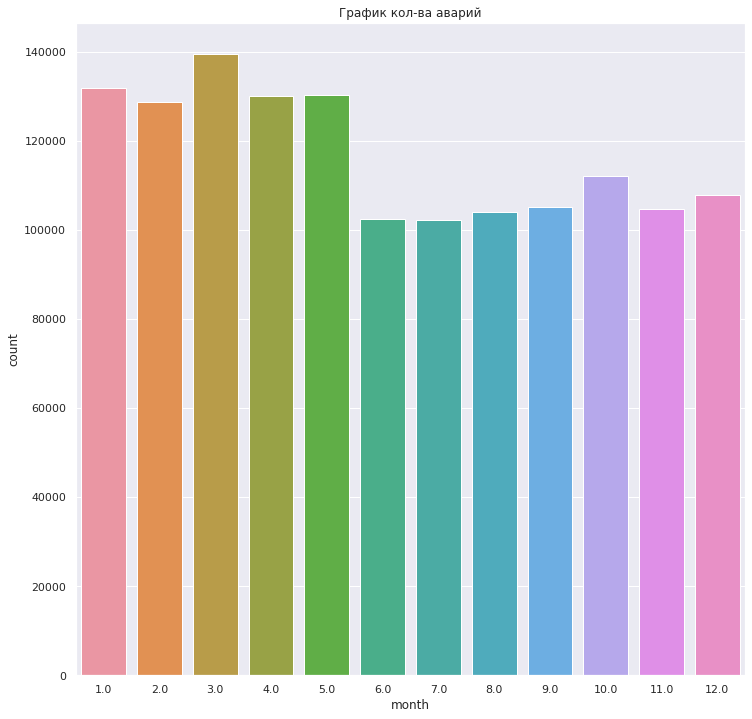

In [29]:
sns.barplot(data=count_collis_month_df, x=count_collis_month_df['month'], y=count_collis_month_df['count'])
plt.title('График кол-ва аварий')
plt.show()

- С января по май происходит больше всего аварий.
- Март самый аварийный.
- Необычно, что в октябре аварий больше чем в декабре.

**Задача 1.** Средняя сумма страховки в зависимости от типа автомобиля.

In [30]:
avg_insur_v_type = '''

SELECT v.vehicle_type, AVG(p.insurance_premium)
FROM vehicles v
JOIN parties p ON v.case_id=p.case_id
GROUP BY v.vehicle_type

'''

In [31]:
avg_insur_v_type_db =  pd.read_sql_query(avg_insur_v_type, con = engine)

In [32]:
avg_insur_v_type_db

,vehicle_type,avg
0,coupe,39.73
1,hatchback,38.18
2,minivan,37.01
3,other,39.71
4,sedan,37.79


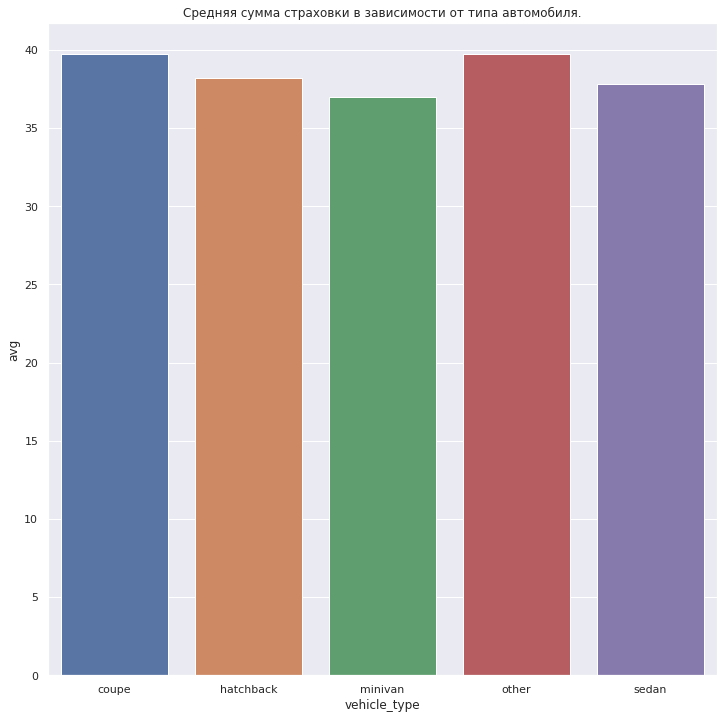

In [33]:
sns.barplot(data=avg_insur_v_type_db, x=avg_insur_v_type_db['vehicle_type'], y=avg_insur_v_type_db['avg'])
plt.title('Средняя сумма страховки в зависимости от типа автомобиля.')
plt.show()

В целом средняя стоимость страховки у разных типов автомобиля на одном уровне. Купе немного лидирует, так как сами автомобили дороже.

**Задача 2.** Топ 10 локаций где произошли аварии по причине нетрезвой езды по пятницам.

In [34]:
top_loc_drink = '''

SELECT c.county_location, COUNT(DISTINCT p.case_id)
FROM collisions c
JOIN parties p ON c.case_id=p.case_id
WHERE p.party_sobriety LIKE '%%had been drinking%%' AND
EXTRACT(DOW FROM c.collision_date) = 5
GROUP BY c.county_location
ORDER BY COUNT(DISTINCT p.case_id) DESC
LIMIT 10

'''

In [35]:
top_loc_drink_db =  pd.read_sql_query(top_loc_drink, con = engine)

In [36]:
top_loc_drink_db

,county_location,count
0,los angeles,6153
1,orange,2110
2,san diego,1663
3,san bernardino,1224
4,riverside,1169
5,alameda,859
6,sacramento,856
7,santa clara,765
8,kern,569
9,ventura,549


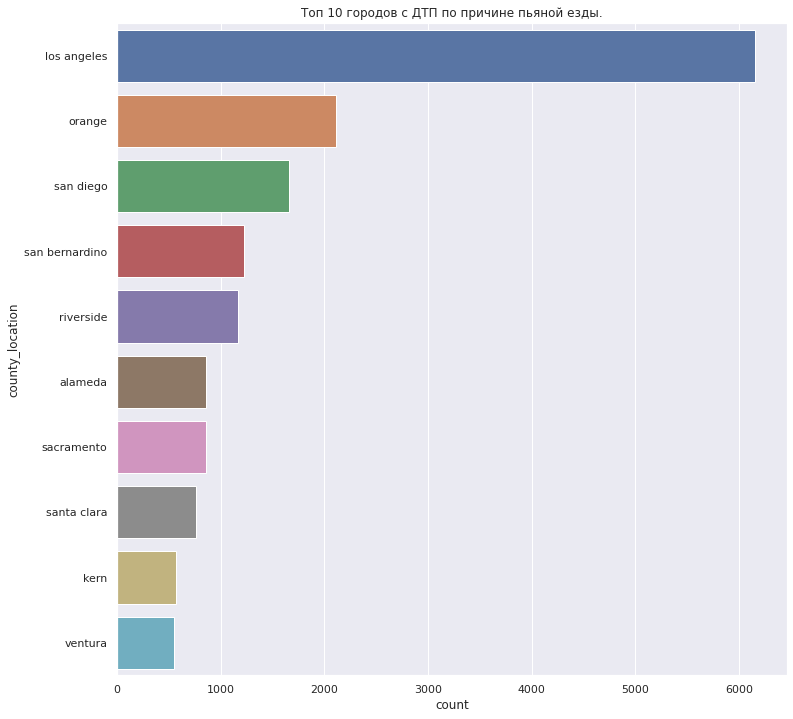

In [37]:
sns.barplot(data=top_loc_drink_db, x=top_loc_drink_db['count'], y=top_loc_drink_db['county_location'])
plt.title('Топ 10 городов с ДТП по причине пьяной езды.')
plt.show()

В целом коррелирует с общем кол-ом ДТП.

**Задача 3.** Кол-во столкновений автомобилей на перекрестке в темное время суток.

**Задача 4.** Кол-во аварий на автомобилях с ручной коробкой передач в ночное время суток.

**Задача 5.** Какой средний возраст автомобиля, который врезался в другой автомобиль.

**Задача 6.** Какой день недели самый аварийный.

## Формирование данных для модели оценки водительского риска

In [38]:
cols_to_use = ['collision_date', #можно выделить месяц, день, день недели. В предпраздничные дни и перед выходными выше шанс
                                #попасть в ДТП.
               'collision_time', #время суток также влияет на риск попасть в ДТП. Например, в конце дня водитель сильнее устал
               'intersection', #перекрестки, особенно нерегулируемые, имеют высокую долю ДТП.
               'weather_1', #в дождь, снегопад сложнее контролировать автомобиль и плохая видимость.
               'road_surface', #если дорога, мокрая, скользкая, то сложнее контролировать автомобиль.
               'lighting', #освещение на дороге может повлиять на скорость реагирования водителя.
               'county_city_location', #в более загруженных городах, больше участников дорожного движения, следовательно
                                       #выше шанс попасть в ДТП.
               'direction', #при определенных обстоятельствах и направлении движения может ослепить солнце.
               'location_type',
               'road_condition_1', #неожиданная яма может заставить водителя совершить рискованный маневр.
               'party_sobriety', #если водитель выпивал, то реакция снижена.
               'cellphone_in_use', #разговаривая по телефону (не используя handsfree), можно отвлечься от дороги
               'vehicle_type', #минивен семейный автомобиль, соотвественно управляют им аккуратнее.
               'vehicle_age', #у старых автомобилей выше риск в отказе одной из сисем (тормоза) или может не работать свет.
               'at_fault' #целевой признак
               ]

In [39]:
collision_risk_2012 = '''

SELECT c.collision_date,
       c.collision_time,
       c.intersection,
       c.weather_1,
       c.road_surface,
       c.lighting,
       c.county_city_location,
       c.direction,
       c.location_type,
       c.road_condition_1,
       p.party_sobriety,
       p.cellphone_in_use,
       v.vehicle_type,
       v.vehicle_age,
       p.at_fault
FROM collisions c
LEFT JOIN parties p ON c.case_id=p.case_id
JOIN vehicles v ON p.case_id=v.case_id AND p.party_number=v.party_number
WHERE p.party_type = 'car'
        AND LOWER(c.collision_damage) != 'scratch'
        AND EXTRACT(YEAR FROM c.collision_date) = 2012
ORDER BY c.case_id;

'''

In [40]:
collision_risk_2012_db =  pd.read_sql_query(collision_risk_2012, con = engine)

In [41]:
collision_risk_2012_db.head()

,collision_date,collision_time,intersection,weather_1,road_surface,lighting,county_city_location,direction,location_type,road_condition_1,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,at_fault
0,2012-03-30,07:40:00,1.00,cloudy,dry,daylight,3712,None,None,other,had not been drinking,0.00,sedan,2.00,0
1,2012-04-02,12:54:00,1.00,clear,dry,daylight,3404,None,None,normal,had not been drinking,0.00,sedan,5.00,0
2,2012-11-13,16:35:00,1.00,clear,dry,daylight,3400,None,None,normal,had not been drinking,0.00,sedan,1.00,0
3,2012-09-05,19:32:00,0.00,clear,dry,dark with street lights,3607,east,None,normal,had not been drinking,0.00,sedan,4.00,0
4,2012-11-03,13:15:00,1.00,clear,dry,daylight,3400,None,None,normal,had not been drinking,0.00,coupe,6.00,0


In [42]:
collision_risk_2012_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   collision_date        56248 non-null  object 
 1   collision_time        56160 non-null  object 
 2   intersection          56073 non-null  float64
 3   weather_1             56080 non-null  object 
 4   road_surface          55900 non-null  object 
 5   lighting              56094 non-null  object 
 6   county_city_location  56248 non-null  object 
 7   direction             43230 non-null  object 
 8   location_type         25932 non-null  object 
 9   road_condition_1      55999 non-null  object 
 10  party_sobriety        55376 non-null  object 
 11  cellphone_in_use      51777 non-null  float64
 12  vehicle_type          56248 non-null  object 
 13  vehicle_age           54554 non-null  float64
 14  at_fault              56248 non-null  int64  
dtypes: float64(3), int6

### Признаки для модели

### Train and Test

In [43]:
X = collision_risk_2012_db.drop(columns='at_fault')
y = collision_risk_2012_db['at_fault']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE,
                                                    stratify=y)

In [44]:
X_train.shape, X_test.shape

((44998, 14), (11250, 14))

In [45]:
X_train.head()

,collision_date,collision_time,intersection,weather_1,road_surface,lighting,county_city_location,direction,location_type,road_condition_1,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age
30611,2012-04-08,16:50:00,0.00,clear,dry,daylight,3020,north,highway,construction,had not been drinking,0.00,sedan,10.00
11278,2012-01-23,04:20:00,0.00,cloudy,wet,dark with no street lights,5000,north,ramp,normal,had not been drinking,0.00,sedan,7.00
28227,2012-03-17,06:21:00,0.00,cloudy,dry,dark with no street lights,3600,north,highway,normal,had not been drinking,0.00,sedan,3.00
9099,2012-01-05,20:25:00,0.00,clear,dry,dark with no street lights,3029,east,None,normal,"had been drinking, under influence",0.00,sedan,3.00
3778,2012-01-02,12:38:00,1.00,clear,dry,daylight,5000,None,None,normal,had not been drinking,0.00,sedan,7.00


In [46]:
for col in X_train.columns:
    pct_missing = np.mean(collision_risk_2012_db[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

collision_date - 0%
collision_time - 0%
intersection - 0%
weather_1 - 0%
road_surface - 1%
lighting - 0%
county_city_location - 0%
direction - 23%
location_type - 54%
road_condition_1 - 0%
party_sobriety - 2%
cellphone_in_use - 8%
vehicle_type - 0%
vehicle_age - 3%


В категориальных признаках пропуски заполню заглушкой. В числовых где пропуски выше 1% использую KNNImputer.

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44998 entries, 30611 to 40490
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   collision_date        44998 non-null  object 
 1   collision_time        44923 non-null  object 
 2   intersection          44850 non-null  float64
 3   weather_1             44865 non-null  object 
 4   road_surface          44727 non-null  object 
 5   lighting              44873 non-null  object 
 6   county_city_location  44998 non-null  object 
 7   direction             34599 non-null  object 
 8   location_type         20772 non-null  object 
 9   road_condition_1      44798 non-null  object 
 10  party_sobriety        44314 non-null  object 
 11  cellphone_in_use      41416 non-null  float64
 12  vehicle_type          44998 non-null  object 
 13  vehicle_age           43636 non-null  float64
dtypes: float64(3), object(11)
memory usage: 5.1+ MB


In [48]:
X_train['collis_day'] = pd.to_datetime(X_train['collision_date']).dt.day
X_train['collis_weekday'] = pd.to_datetime(X_train['collision_date']).dt.weekday
X_train['collis_month'] = pd.to_datetime(X_train['collision_date']).dt.month
X_train['collis_hour'] = pd.to_datetime(X_train['collision_time'], format='%H:%M:%S').dt.hour

In [49]:
X_test['collis_day'] = pd.to_datetime(X_test['collision_date']).dt.day
X_test['collis_weekday'] = pd.to_datetime(X_test['collision_date']).dt.weekday
X_test['collis_month'] = pd.to_datetime(X_test['collision_date']).dt.month
X_test['collis_hour'] = pd.to_datetime(X_test['collision_time'], format='%H:%M:%S').dt.hour

In [50]:
X_train.drop(columns=['collision_date', 'collision_time'], axis=1, inplace=True)

In [51]:
X_test.drop(columns=['collision_date', 'collision_time'], axis=1, inplace=True)

In [52]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44998 entries, 30611 to 40490
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   intersection          44850 non-null  float64
 1   weather_1             44865 non-null  object 
 2   road_surface          44727 non-null  object 
 3   lighting              44873 non-null  object 
 4   county_city_location  44998 non-null  object 
 5   direction             34599 non-null  object 
 6   location_type         20772 non-null  object 
 7   road_condition_1      44798 non-null  object 
 8   party_sobriety        44314 non-null  object 
 9   cellphone_in_use      41416 non-null  float64
 10  vehicle_type          44998 non-null  object 
 11  vehicle_age           43636 non-null  float64
 12  collis_day            44998 non-null  int64  
 13  collis_weekday        44998 non-null  int64  
 14  collis_month          44998 non-null  int64  
 15  collis_hour    

In [53]:
X_train.intersection.isnull().sum() / X_train.shape[0] * 100

0.32890350682252545

Кол-во пропусков в признаке менее процента. Считаю, что их можно удалить.

In [54]:
indexes_to_drop = X_train[X_train['intersection'].isna()].index

In [55]:
X_train.dropna(subset=['intersection'], inplace=True)
X_train.reset_index(drop=True, inplace=True)

In [56]:
y_train = y_train.drop(indexes_to_drop).reset_index(drop=True)

In [57]:
X_train.shape, y_train.shape

((44850, 16), (44850,))

In [58]:
X_train.county_city_location.value_counts()

1942    5509
1900    1786
3711    1030
3400     868
3600     802
        ... 
4701       1
1102       1
5702       1
1305       1
1504       1
Name: county_city_location, Length: 490, dtype: int64

count   43494.00
mean        4.86
std         3.27
min         0.00
25%         3.00
50%         4.00
75%         7.00
max       161.00
Name: vehicle_age, dtype: float64

Верхний ус: 13.0 
Нижний ус: -3.0     
Медианное значение: 4.0


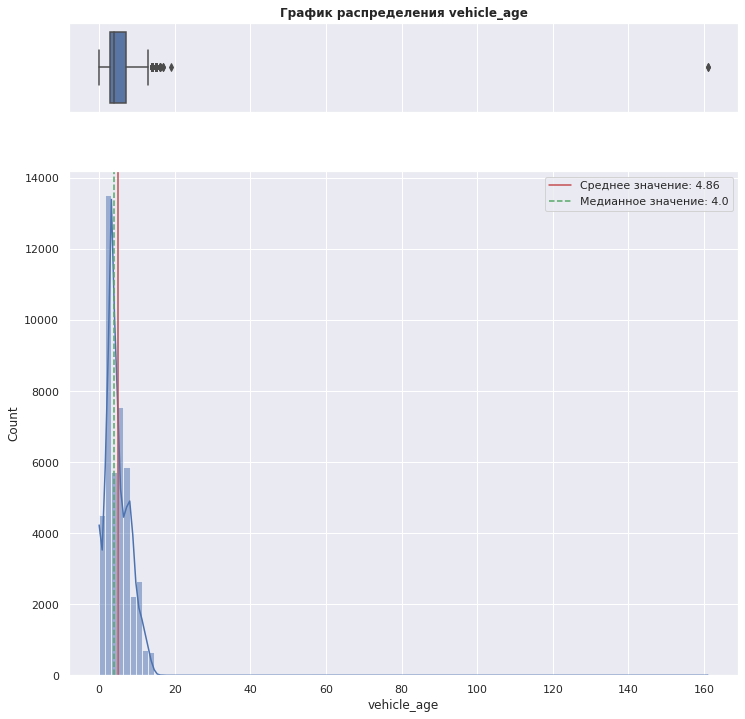

In [59]:
numeric_analysis(X_train, 'vehicle_age', 'vehicle_age')

In [60]:
indexes_to_drop = X_train[X_train['vehicle_age'] == 161].index

In [61]:
X_train = X_train.drop(indexes_to_drop).reset_index(drop=True)

In [62]:
y_train = y_train.drop(indexes_to_drop).reset_index(drop=True)

count   43492.00
mean        4.86
std         3.10
min         0.00
25%         3.00
50%         4.00
75%         7.00
max        19.00
Name: vehicle_age, dtype: float64

Верхний ус: 13.0 
Нижний ус: -3.0     
Медианное значение: 4.0


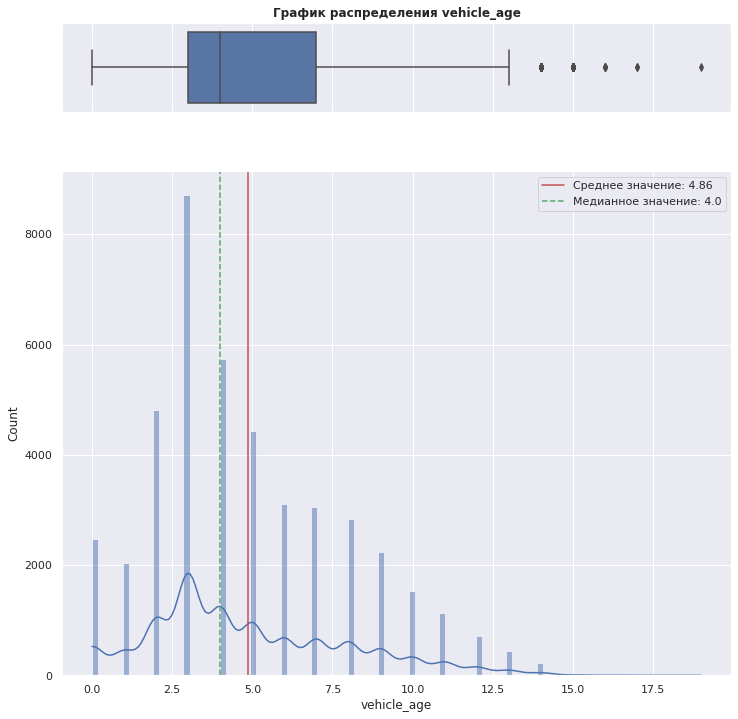

In [63]:
numeric_analysis(X_train, 'vehicle_age', 'vehicle_age')

Признак больше похож на категориальный.

In [64]:
X_train['vehicle_age'].value_counts()

3.00     8708
4.00     5729
2.00     4814
5.00     4436
6.00     3113
7.00     3046
8.00     2834
0.00     2477
9.00     2237
1.00     2039
10.00    1529
11.00    1127
12.00     705
13.00     434
14.00     225
15.00      31
16.00       5
17.00       2
19.00       1
Name: vehicle_age, dtype: int64

In [65]:
indexes_to_drop = X_train[X_train['vehicle_age'] > 10].index

In [66]:
X_train = X_train.drop(indexes_to_drop).reset_index(drop=True)
y_train = y_train.drop(indexes_to_drop).reset_index(drop=True)

count   40962.00
mean        4.42
std         2.61
min         0.00
25%         3.00
50%         4.00
75%         6.00
max        10.00
Name: vehicle_age, dtype: float64

Верхний ус: 10.5 
Нижний ус: -1.5     
Медианное значение: 4.0


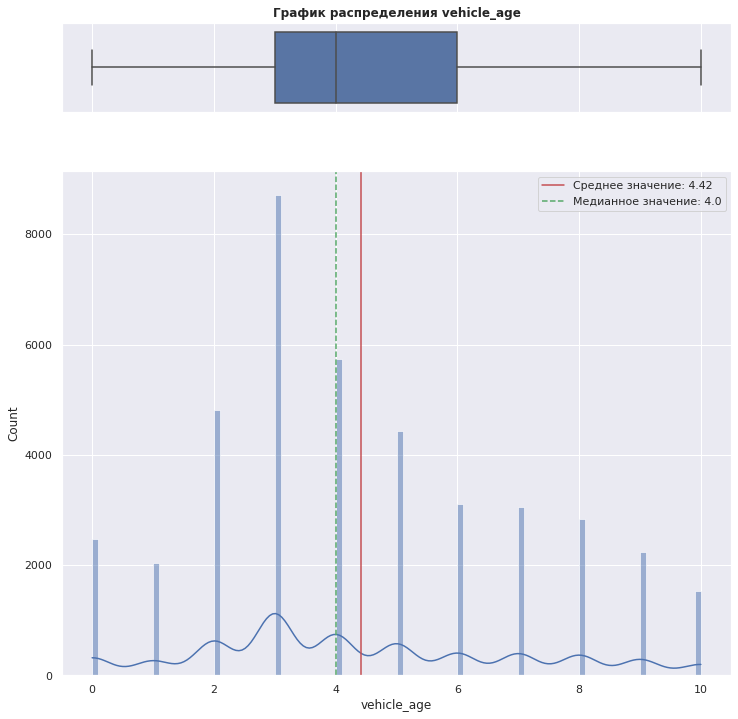

In [67]:
numeric_analysis(X_train, 'vehicle_age', 'vehicle_age')

Больше всего 3-х летних автомобилей.

count   42318.00
mean       15.33
std         8.71
min         1.00
25%         8.00
50%        15.00
75%        23.00
max        31.00
Name: collis_day, dtype: float64

Верхний ус: 45.5 
Нижний ус: -14.5     
Медианное значение: 15.0


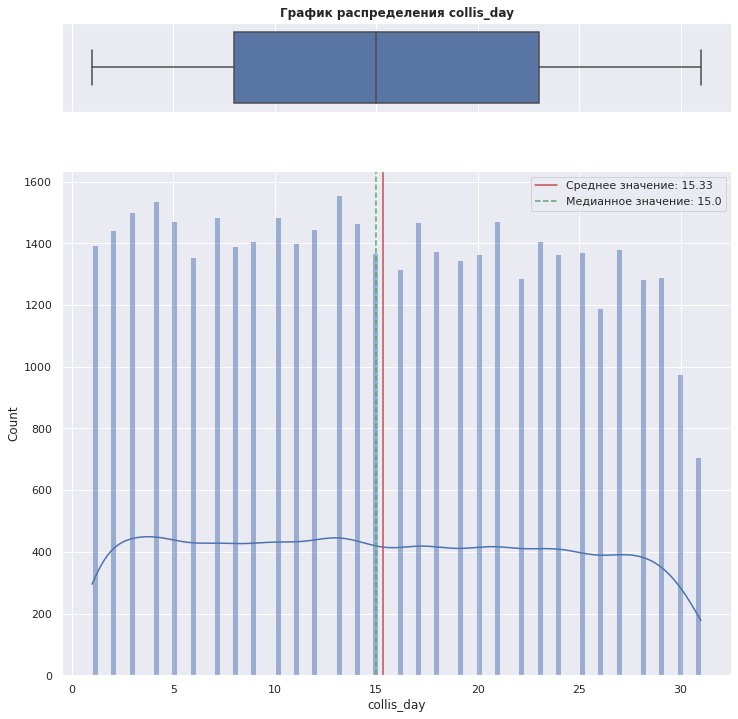

In [68]:
numeric_analysis(X_train, 'collis_day', 'collis_day')

30 и 31 дни меньше всего ДТП.

In [69]:
X_train['collis_weekday'].value_counts()

5    7127
4    6962
6    6135
3    5735
2    5641
1    5366
0    5352
Name: collis_weekday, dtype: int64

count   42318.00
mean        3.17
std         1.97
min         0.00
25%         1.00
50%         3.00
75%         5.00
max         6.00
Name: collis_weekday, dtype: float64

Верхний ус: 11.0 
Нижний ус: -5.0     
Медианное значение: 3.0


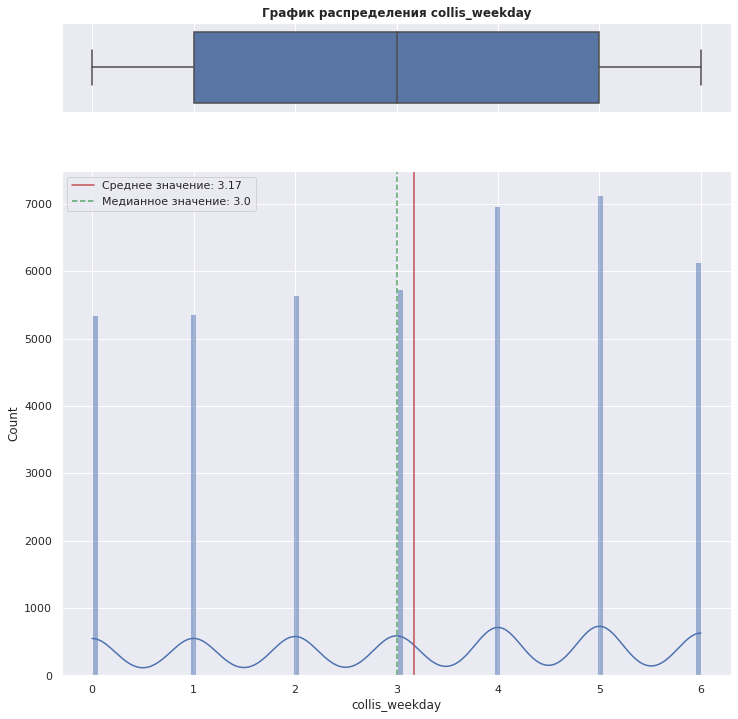

In [70]:
numeric_analysis(X_train, 'collis_weekday', 'collis_weekday')

Пятница и суббоат самые аварийные.

count   42318.00
mean        3.23
std         1.80
min         1.00
25%         2.00
50%         3.00
75%         4.00
max        12.00
Name: collis_month, dtype: float64

Верхний ус: 7.0 
Нижний ус: -1.0     
Медианное значение: 3.0


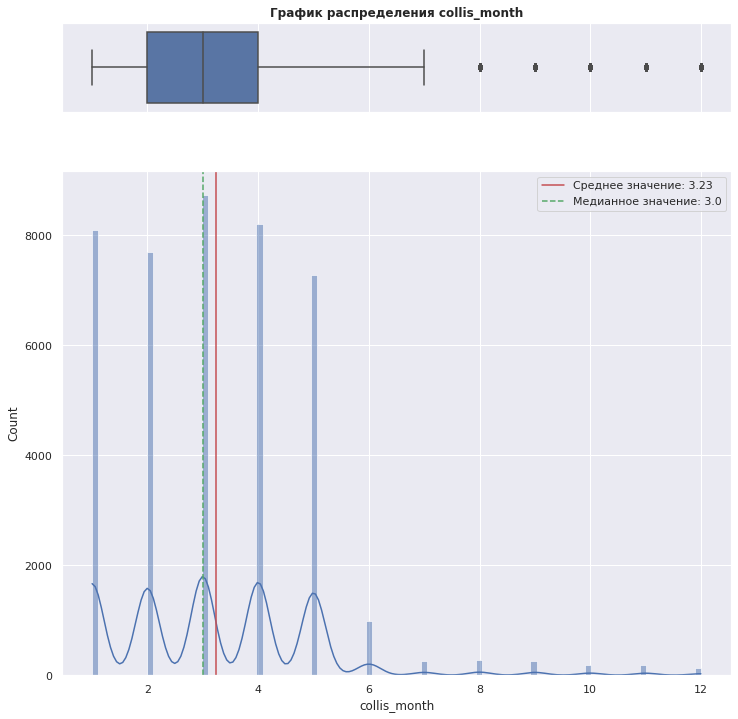

In [71]:
numeric_analysis(X_train, 'collis_month', 'collis_month')

In [72]:
X_train.collis_month.value_counts()

3     8732
4     8216
1     8104
2     7691
5     7286
6      988
8      277
9      256
7      255
10     192
11     186
12     135
Name: collis_month, dtype: int64

Считаю, что признак сломан. После мая низкое кол-во зафиксированныйх ДТП.

In [73]:
X_train.drop(columns=['collis_month'], axis=1, inplace=True)

In [74]:
X_test.drop(columns=['collis_month'], axis=1, inplace=True)

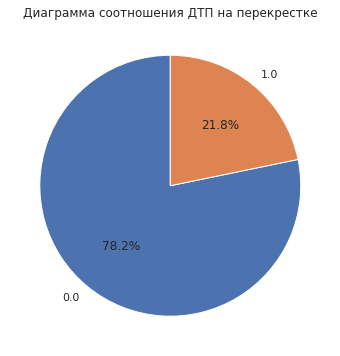

In [75]:
plt.figure(figsize=(6, 6))
plt.pie(X_train['intersection'].value_counts(), labels=['0.0', '1.0'], autopct='%1.1f%%', startangle=90)
plt.title('Диаграмма соотношения ДТП на перекрестке')
plt.show()

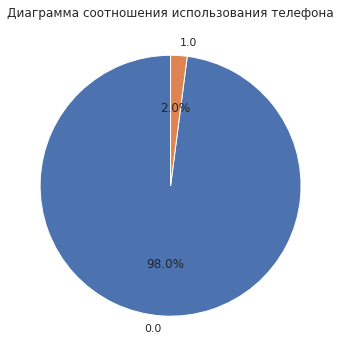

In [76]:
plt.figure(figsize=(6, 6))
plt.pie(X_train['cellphone_in_use'].value_counts(), labels=['0.0', '1.0'], autopct='%1.1f%%', startangle=90)
plt.title('Диаграмма соотношения использования телефона')
plt.show()

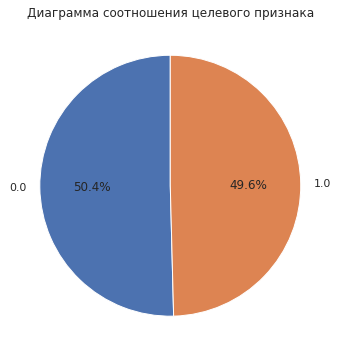

In [77]:
plt.figure(figsize=(6, 6))
plt.pie(y_train.value_counts(), labels=['0.0', '1.0'], autopct='%1.1f%%', startangle=90)
plt.title('Диаграмма соотношения целевого признака')
plt.show()

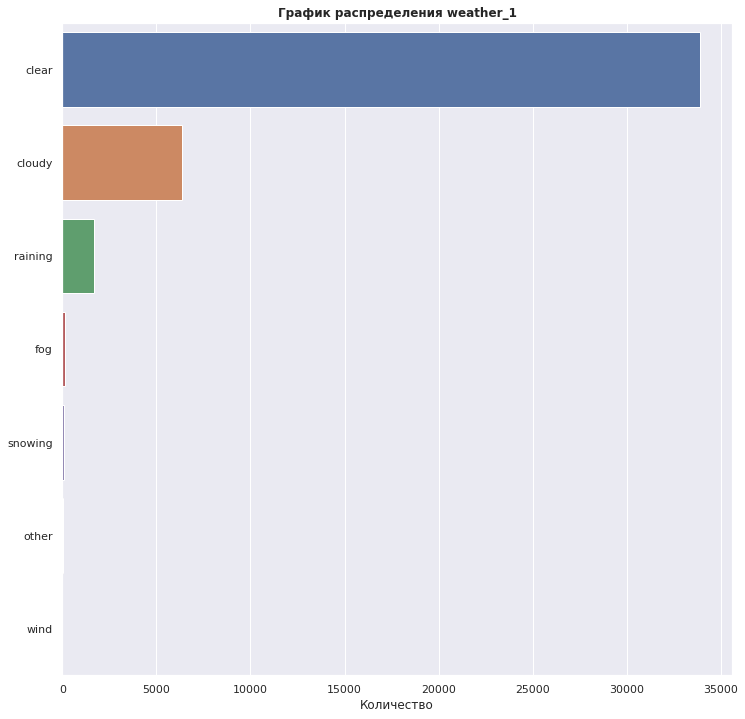

clear      33891
cloudy      6347
raining     1668
fog          136
snowing      115
other         28
wind           8
Name: weather_1, dtype: int64

In [78]:
cat_vis(X_train, 'weather_1')

In [79]:
weather_replacements = {
    'cloudy': 'cloudy/precipitation',
    'raining': 'cloudy/precipitation',
    'snowing': 'cloudy/precipitation',
    'fog': 'other',
    'wind': 'other'
}

X_train['weather_1_cat'] = X_train['weather_1'].replace(weather_replacements)

In [80]:
X_test['weather_1_cat'] = X_test['weather_1'].replace(weather_replacements)

In [81]:
X_train.drop('weather_1', axis=1, inplace=True)

In [82]:
X_test.drop('weather_1', axis=1, inplace=True)

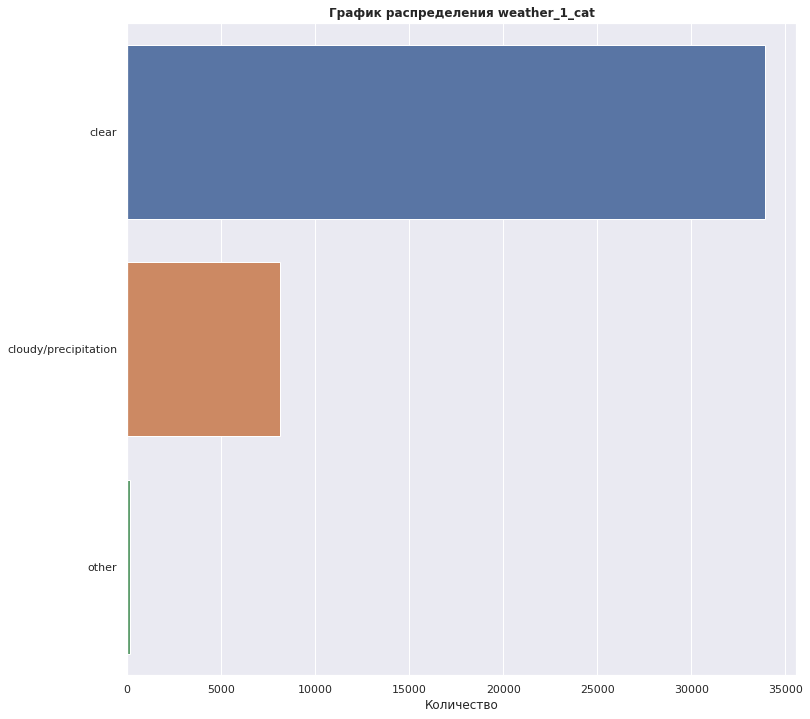

clear                   33891
cloudy/precipitation     8130
other                     172
Name: weather_1_cat, dtype: int64

In [83]:
cat_vis(X_train, 'weather_1_cat')

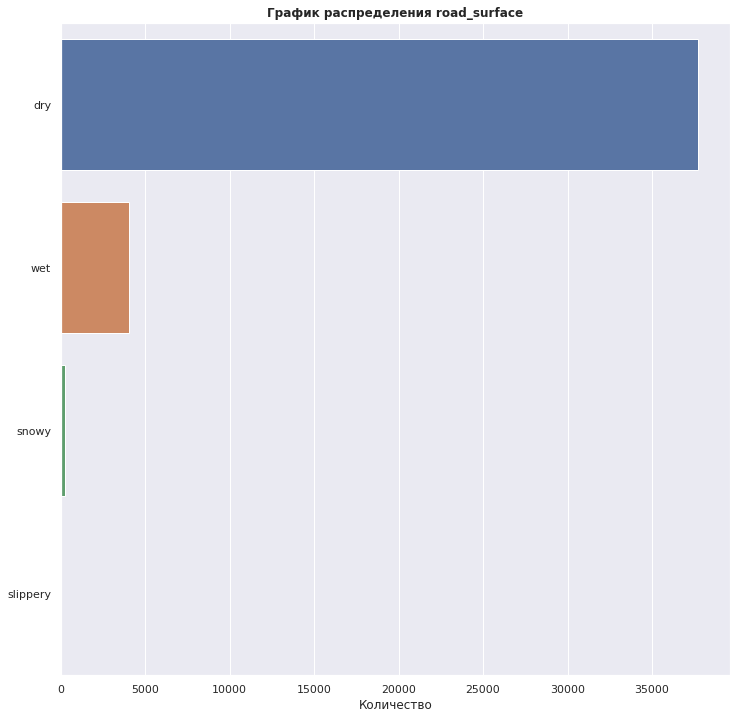

dry         37747
wet          4019
snowy         271
slippery       30
Name: road_surface, dtype: int64

In [84]:
cat_vis(X_train, 'road_surface')

In [85]:
road_surface_replace = {
    'wet': 'slippery',
    'snowy': 'slippery'
}

X_train['road_surface_cat'] = X_train['road_surface'].replace(road_surface_replace)

In [86]:
X_test['road_surface_cat'] = X_test['road_surface'].replace(road_surface_replace)

In [87]:
X_train.drop('road_surface', axis=1, inplace=True)

In [88]:
X_test.drop('road_surface', axis=1, inplace=True)

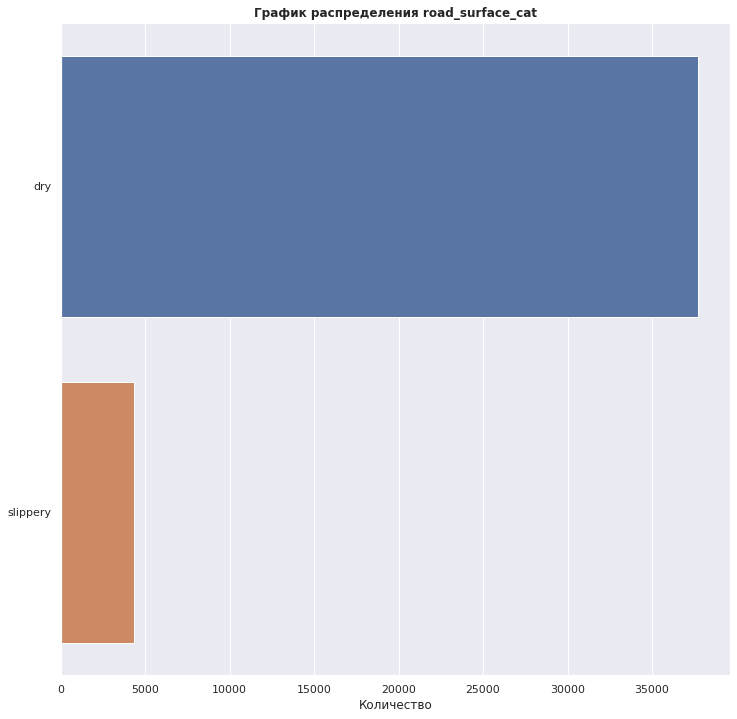

dry         37747
slippery     4320
Name: road_surface_cat, dtype: int64

In [89]:
cat_vis(X_train, 'road_surface_cat')

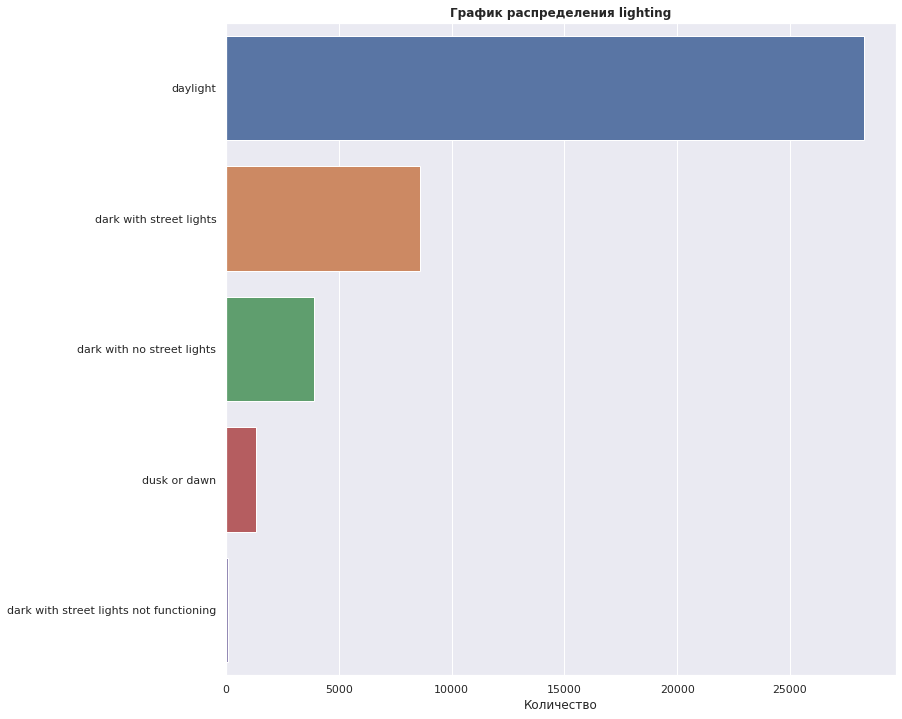

daylight                                   28262
dark with street lights                     8596
dark with no street lights                  3908
dusk or dawn                                1325
dark with street lights not functioning      107
Name: lighting, dtype: int64

In [90]:
cat_vis(X_train, 'lighting')

In [91]:
X_train['lighting'] = (X_train['lighting'].
                                      str.replace('dark with street lights not functioning', 'dark with no street lights'))

In [92]:
X_test['lighting'] = (X_test['lighting'].
                                      str.replace('dark with street lights not functioning', 'dark with no street lights'))

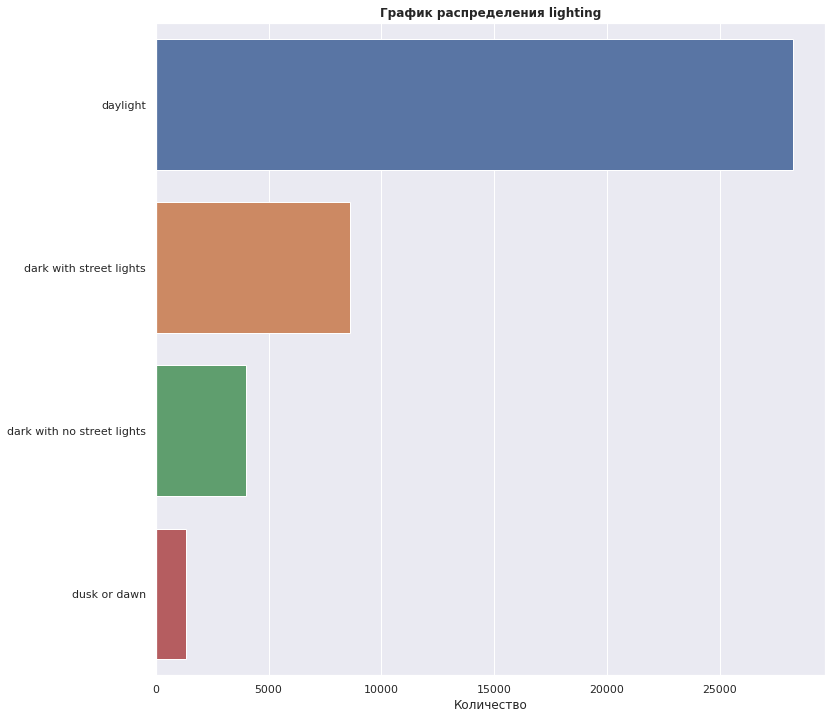

daylight                      28262
dark with street lights        8596
dark with no street lights     4015
dusk or dawn                   1325
Name: lighting, dtype: int64

In [93]:
cat_vis(X_train, 'lighting')

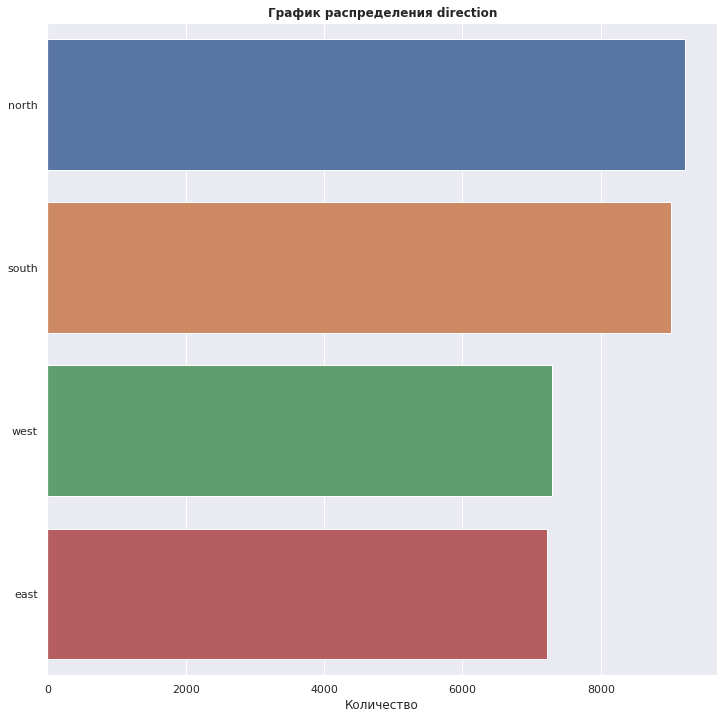

north    9219
south    9018
west     7287
east     7225
Name: direction, dtype: int64

In [94]:
cat_vis(X_train, 'direction')

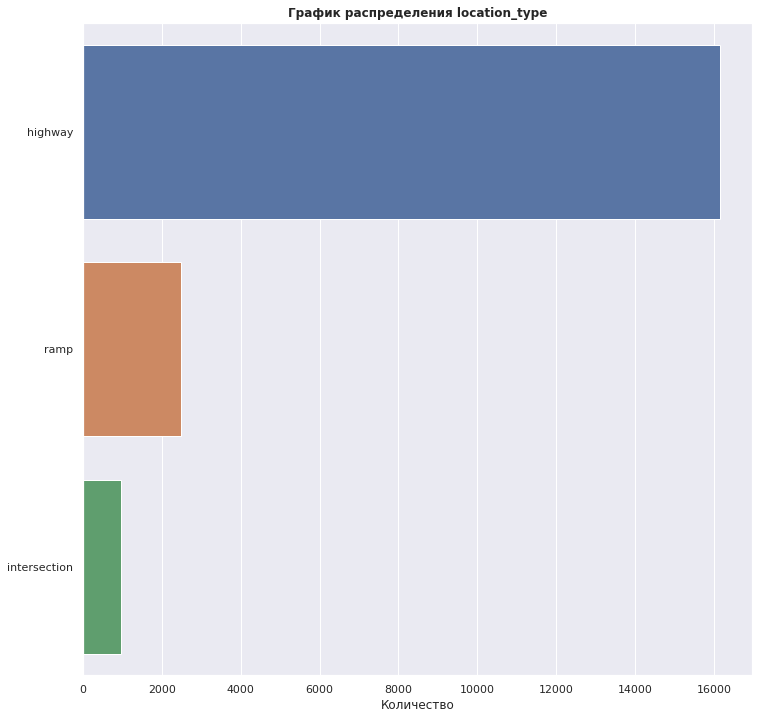

highway         16156
ramp             2496
intersection      964
Name: location_type, dtype: int64

In [95]:
cat_vis(X_train, 'location_type')

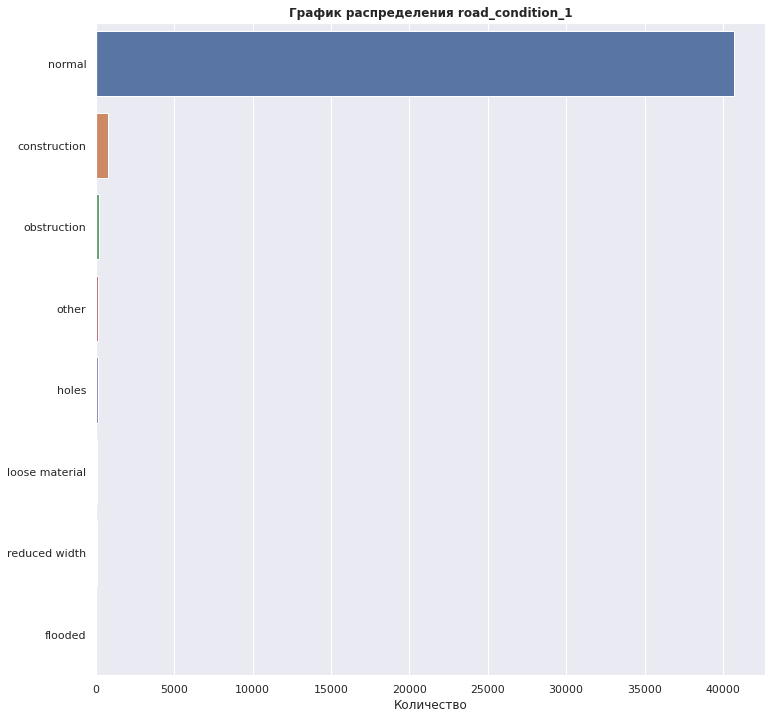

normal            40678
construction        759
obstruction         194
other               169
holes               158
loose material       97
reduced width        51
flooded              23
Name: road_condition_1, dtype: int64

In [96]:
cat_vis(X_train, 'road_condition_1')

In [97]:
road_cond_replace = {'construction' : 'bad',
                     'holes': 'bad',
                     'reduced width': 'bad',
                     'flooded': 'bad',
                     'loose material': 'bad',
                     'obstruction': 'other'
                    }

X_train['road_condition_1_cat'] = X_train['road_condition_1'].replace(road_cond_replace)

In [98]:
X_test['road_condition_1_cat'] = X_test['road_condition_1'].replace(road_cond_replace)

In [99]:
X_train.drop('road_condition_1', axis=1, inplace=True)

In [100]:
X_test.drop('road_condition_1', axis=1, inplace=True)

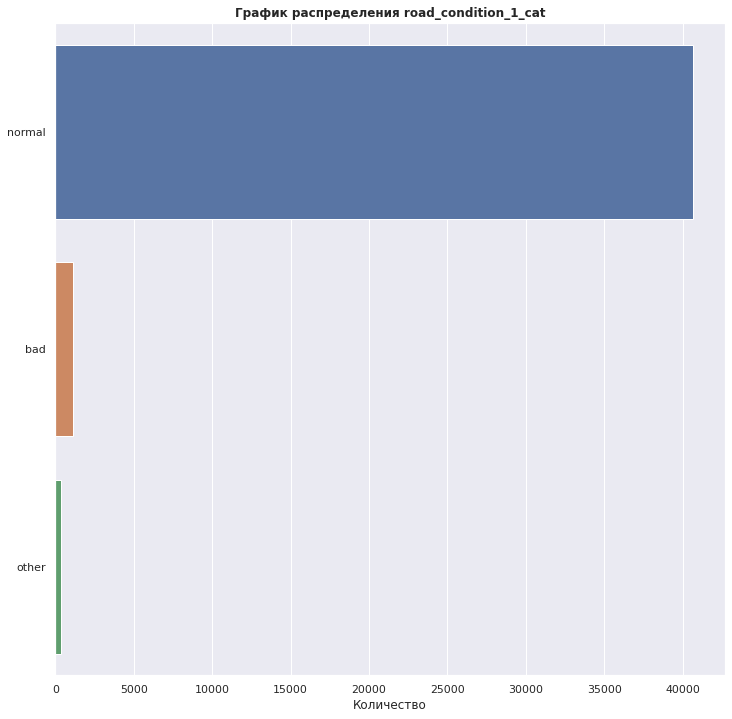

normal    40678
bad        1088
other       363
Name: road_condition_1_cat, dtype: int64

In [101]:
cat_vis(X_train, 'road_condition_1_cat')

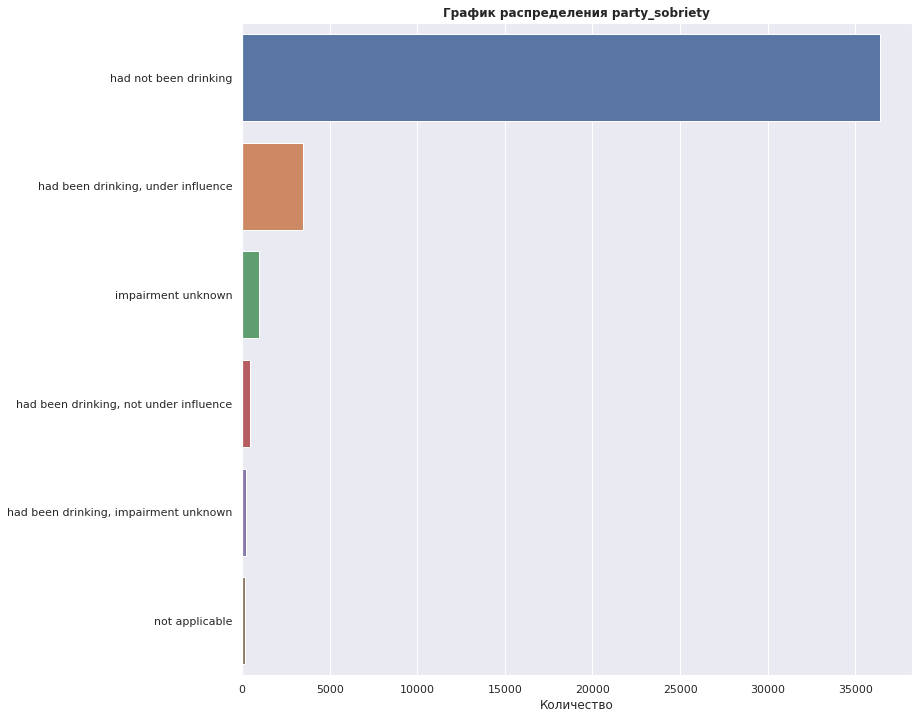

had not been drinking                     36397
had been drinking, under influence         3503
impairment unknown                          956
had been drinking, not under influence      426
had been drinking, impairment unknown       210
not applicable                              188
Name: party_sobriety, dtype: int64

In [102]:
cat_vis(X_train, 'party_sobriety')

In [103]:
soberty_replace = {'impairment unknown' : 'other',
                     'not applicable': 'other',
                     'had been drinking, under influence': 'had been drinking',
                     'had been drinking, impairment unknown': 'had been drinking',
                     'had been drinking, not under influence': 'had been drinking'
                    }

X_train['party_sobriety_cat'] = X_train['party_sobriety'].replace(soberty_replace)

In [104]:
X_test['party_sobriety_cat'] = X_test['party_sobriety'].replace(soberty_replace)

In [105]:
X_train.drop('party_sobriety', axis=1, inplace=True)

In [106]:
X_test.drop('party_sobriety', axis=1, inplace=True)

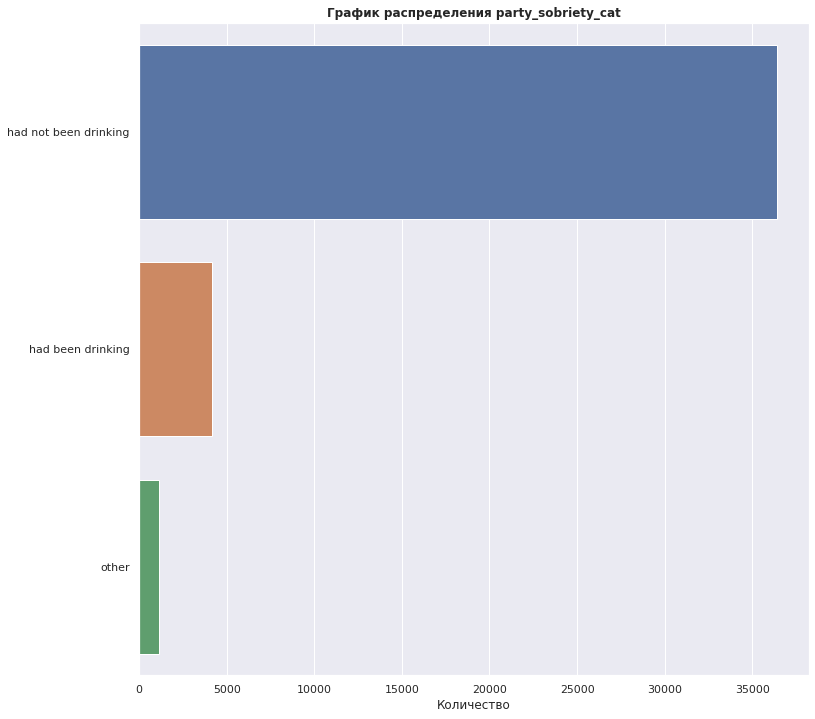

had not been drinking    36397
had been drinking         4139
other                     1144
Name: party_sobriety_cat, dtype: int64

In [107]:
cat_vis(X_train, 'party_sobriety_cat')

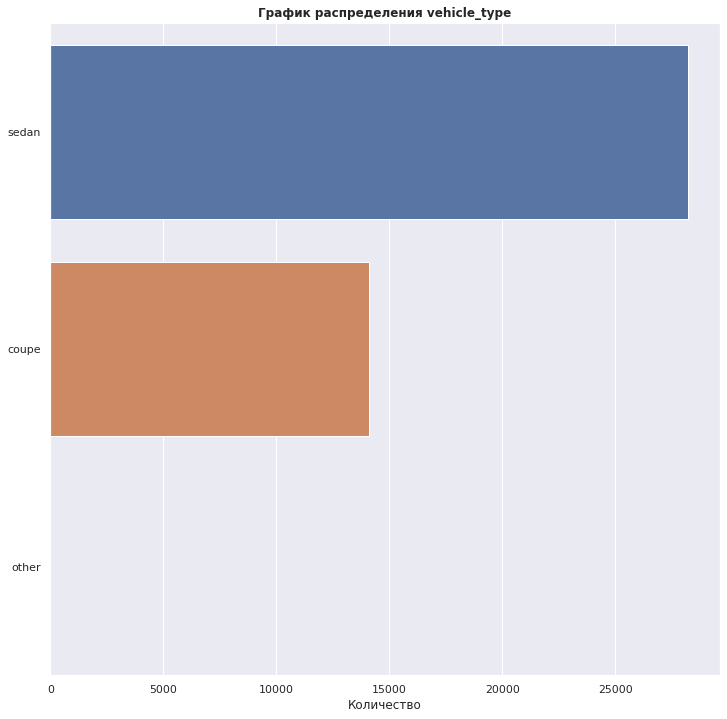

sedan    28219
coupe    14097
other        2
Name: vehicle_type, dtype: int64

In [108]:
cat_vis(X_train, 'vehicle_type')

In [109]:
vhcl_type_replace = {'hatchback' : 'other',
                     'minivan': 'other'
                    }

X_train['vehicle_type_cat'] = X_train['vehicle_type'].replace(vhcl_type_replace)

In [110]:
X_test['vehicle_type_cat'] = X_test['vehicle_type'].replace(vhcl_type_replace)

In [111]:
X_train.drop('vehicle_type', axis=1, inplace=True)

In [112]:
X_test.drop('vehicle_type', axis=1, inplace=True)

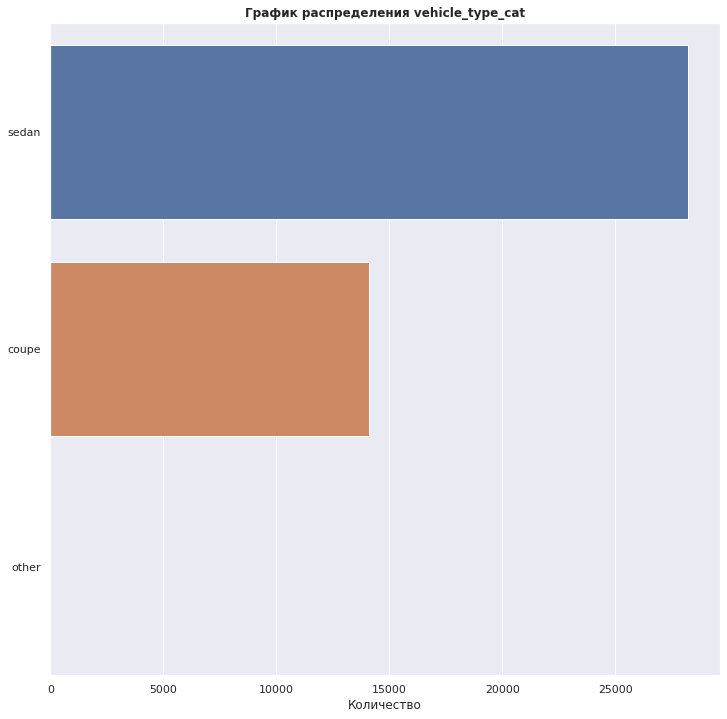

sedan    28219
coupe    14097
other        2
Name: vehicle_type_cat, dtype: int64

In [113]:
cat_vis(X_train, 'vehicle_type_cat')

- Во всех категориальных признаках дисбаланс, скорее всего это связано с тем, что большую долю в данных занимают крупные города, например, Los Angeles.
- В связи этим, больше всего аварий на хороших дорогах.
- Высокое кол-во ДТП с участием седанов и купе, т.к. они дороже прочих и более популярны именно в городе.

## Корреляционный анализ

In [114]:
num_cols = X_train.drop(['intersection', 'cellphone_in_use'],
                    axis=1).select_dtypes(include='number').columns.tolist()

In [115]:
corr = X_train.sample(n=1000, random_state=RANDOM_STATE).phik_matrix(interval_cols=num_cols)

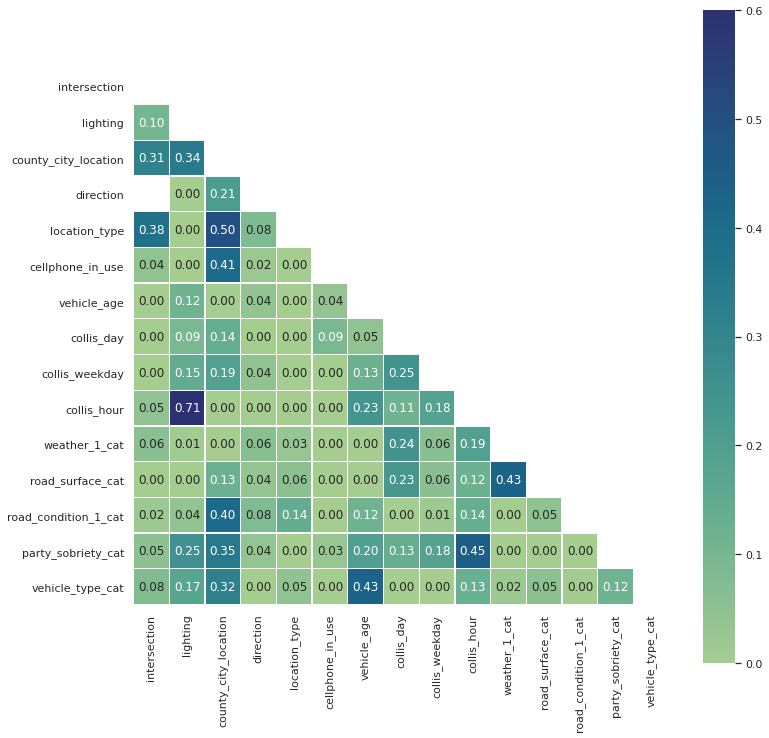

In [116]:
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_theme(style="white")
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(corr, mask=mask,
            square=True,
            linewidths=.3,
            vmax=0.6,
            annot=True,
            cmap=cmap,
            fmt='.2f')

plt.show()

В целом данные коррелируют слабо, за исключением collis_hour и lighting, что логично. 
Также есть выделяется корреляция между location_type и county_city_location, что также связано с большой долей данных по крупныи городам Калифорнии. 

## Pipeline

In [117]:
X_train.columns

Index(['intersection', 'lighting', 'county_city_location', 'direction',
       'location_type', 'cellphone_in_use', 'vehicle_age', 'collis_day',
       'collis_weekday', 'collis_hour', 'weather_1_cat', 'road_surface_cat',
       'road_condition_1_cat', 'party_sobriety_cat', 'vehicle_type_cat'],
      dtype='object')

In [118]:
ohe_cols = ['lighting', 'direction', 'location_type', 
            'weather_1_cat', 'road_surface_cat',
            'road_condition_1_cat', 'party_sobriety_cat',
            'vehicle_type_cat']
counter_cols = ['county_city_location']
impute_cols = ['cellphone_in_use']
num_knn_cols = ['collis_day','collis_weekday', 'collis_hour', 'vehicle_age']

In [119]:
scoring = {'f1_score': 'f1',
           'recall': make_scorer(recall_score)}

Для целей бизнеса лучше всего подходит метрика RECALL, так как необходимо снизить кол-во ложно отрицательных предсказаний, т.е. водителей с высокой вероятностью попасть в ДТП.

### Logistic Regression

In [120]:
logr_ohe_pipe = Pipeline(
    [
        (
            'imputer',
            SimpleImputer(fill_value='other', strategy='constant', copy=False)
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [121]:
logr_impute_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent', copy=False))])

In [122]:
logr_num_knn_pipe = Pipeline(
    [
        ('imputer', KNNImputer(n_neighbors=5, weights='distance')),
        ('scaler', StandardScaler())
    ]
)

In [123]:
logr_preprocessor = ColumnTransformer(
    [
        ('ohe', logr_ohe_pipe, ohe_cols),
        ('cat_imputer', logr_impute_pipe, impute_cols),
        ('counter', CountEncoder(), counter_cols),
        ('num', logr_num_knn_pipe, num_knn_cols)
    ],
    remainder='passthrough'
)

In [124]:
logr_pipe = Pipeline([
    ('preprocessor', logr_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))
])

In [125]:
logr_param_grid = [
    {
        'models__C': [0.01, 0.1, 1, 10],
        'preprocessor__num__scaler': [RobustScaler(), PowerTransformer(), 'passthrough']
    }
]

In [126]:
logr_rndscv = RandomizedSearchCV(
    estimator=logr_pipe,
    param_distributions=logr_param_grid,
    scoring=scoring,
    n_jobs=-1,
    cv=3,
    random_state=RANDOM_STATE,
    refit='f1_score'
)

In [127]:
logr_rndscv.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(copy=False,
                                                                                                              fill_value='other',
                                                                                                              strategy='constant')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['lighting',
                                                                                'direction',
                                                                                'location_type',
                                                                                'weath...
                                                                                'collis_hour',
                                                                                'vehicle_age'])])),
                                             ('models',
                                              LogisticRegression(n_jobs=-1,
                                                                 random_state=15))]),
                   n_jobs=-1,
                   param_distributions=[{'models__C': [0.01, 0.1, 1, 10],
                                         'preprocessor__num__scaler': [RobustScaler(),
                                                                       PowerTransformer(),
                                                                       'passthrough']}],
                   random_state=15, refit='f1_score',
                   scoring={'f1_score': 'f1',
                            'recall': make_scorer(recall_score, response_method='predict')})

In [128]:
pd.DataFrame(logr_rndscv.cv_results_).sort_values(by='rank_test_f1_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__scaler,param_models__C,params,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall
1,6.23,0.09,1.90,0.01,RobustScaler(),1.00,"{'preprocessor__num__scaler': RobustScaler(), ...",0.61,0.59,0.59,0.59,0.01,1,0.56,0.54,0.53,0.54,0.01,1
4,6.44,0.04,1.88,0.08,RobustScaler(),10.00,"{'preprocessor__num__scaler': RobustScaler(), ...",0.60,0.58,0.59,0.59,0.01,2,0.55,0.53,0.55,0.54,0.01,2
9,6.43,0.12,1.93,0.09,PowerTransformer(),10.00,{'preprocessor__num__scaler': PowerTransformer...,0.61,0.58,0.59,0.59,0.01,3,0.56,0.51,0.53,0.54,0.02,3
3,6.46,0.12,1.87,0.05,PowerTransformer(),0.01,{'preprocessor__num__scaler': PowerTransformer...,0.60,0.58,0.59,0.59,0.01,4,0.54,0.53,0.53,0.53,0.01,5
5,6.33,0.12,1.96,0.04,RobustScaler(),0.10,"{'preprocessor__num__scaler': RobustScaler(), ...",0.59,0.58,0.59,0.59,0.00,5,0.53,0.53,0.53,0.53,0.00,6


### RandomForest

In [129]:
rf_ohe_pipe = Pipeline(
    [
        (
            'imputer',
            SimpleImputer(fill_value='other', strategy='constant', copy=False)
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [130]:
rf_impute_pipe = Pipeline([('imputer',SimpleImputer(strategy='most_frequent', copy=False))])

In [131]:
rf_knn_pipe = Pipeline(
    [
        ('imputer', KNNImputer(n_neighbors=5, weights='distance'))
    ]
)

In [132]:
rf_preprocessor = ColumnTransformer(
    [
        ('ohe', rf_ohe_pipe, ohe_cols),
        ('cat_imputer', rf_impute_pipe, impute_cols),
        ('counter', CountEncoder(), counter_cols),
        ('num', rf_knn_pipe, num_knn_cols)
    ],
    remainder='passthrough'
)

In [133]:
rf_pipe = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('models', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

In [134]:
rf_param_grid = [
    {
        'models__n_estimators': range(10, 150, 20),
        'models__max_depth': range(5, 20, 5),
        'models__min_samples_split': range(5, 20, 5),
        'models__min_samples_leaf': range(5, 20, 5),
        'models__criterion': ['gini', 'entropy', 'log_loss']
    }
]

In [135]:
rf_rndscv = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_grid,
    scoring=scoring,
    n_jobs=-1,
    cv=3,
    random_state=RANDOM_STATE,
    refit='f1_score'
)

In [136]:
rf_rndscv.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(copy=False,
                                                                                                              fill_value='other',
                                                                                                              strategy='constant')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['lighting',
                                                                                'direction',
                                                                                'location_type',
                                                                                'weath...
                   param_distributions=[{'models__criterion': ['gini',
                                                               'entropy',
                                                               'log_loss'],
                                         'models__max_depth': range(5, 20, 5),
                                         'models__min_samples_leaf': range(5, 20, 5),
                                         'models__min_samples_split': range(5, 20, 5),
                                         'models__n_estimators': range(10, 150, 20)}],
                   random_state=15, refit='f1_score',
                   scoring={'f1_score': 'f1',
                            'recall': make_scorer(recall_score, response_method='predict')})

In [137]:
pd.DataFrame(rf_rndscv.cv_results_).sort_values(by='rank_test_f1_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__n_estimators,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_depth,param_models__criterion,params,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall
9,3.83,0.00,1.77,0.05,50,10,15,15,log_loss,"{'models__n_estimators': 50, 'models__min_samp...",0.59,0.59,0.57,0.59,0.01,1,0.51,0.52,0.49,0.51,0.01,1
4,4.87,0.05,1.85,0.03,110,10,10,15,entropy,"{'models__n_estimators': 110, 'models__min_sam...",0.59,0.59,0.58,0.59,0.01,2,0.51,0.51,0.49,0.50,0.01,2
1,4.90,0.04,1.89,0.01,130,15,10,10,log_loss,"{'models__n_estimators': 130, 'models__min_sam...",0.58,0.58,0.57,0.58,0.00,3,0.48,0.49,0.48,0.48,0.01,4
0,3.77,0.03,1.75,0.05,50,10,5,10,log_loss,"{'models__n_estimators': 50, 'models__min_samp...",0.58,0.57,0.57,0.58,0.00,4,0.49,0.48,0.48,0.48,0.00,3
2,4.56,0.06,1.84,0.02,110,5,10,10,gini,"{'models__n_estimators': 110, 'models__min_sam...",0.58,0.58,0.57,0.57,0.01,5,0.48,0.49,0.47,0.48,0.01,6


### LightGBM

In [138]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42318 entries, 0 to 42317
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   intersection          42318 non-null  float64
 1   lighting              42198 non-null  object 
 2   county_city_location  42318 non-null  object 
 3   direction             32749 non-null  object 
 4   location_type         19616 non-null  object 
 5   cellphone_in_use      38964 non-null  float64
 6   vehicle_age           40962 non-null  float64
 7   collis_day            42318 non-null  int64  
 8   collis_weekday        42318 non-null  int64  
 9   collis_hour           42247 non-null  float64
 10  weather_1_cat         42193 non-null  object 
 11  road_surface_cat      42067 non-null  object 
 12  road_condition_1_cat  42129 non-null  object 
 13  party_sobriety_cat    41680 non-null  object 
 14  vehicle_type_cat      42318 non-null  object 
dtypes: float64(4), int6

In [139]:
imputer = SimpleImputer(fill_value='other', strategy='constant', copy=False)
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

In [140]:
cat_cols = X_train.select_dtypes(exclude='number').columns.tolist()
num_cols = X_train.select_dtypes(include='number').columns.tolist()

In [141]:
cat_cols

['lighting',
 'county_city_location',
 'direction',
 'location_type',
 'weather_1_cat',
 'road_surface_cat',
 'road_condition_1_cat',
 'party_sobriety_cat',
 'vehicle_type_cat']

In [142]:
num_cols

['intersection',
 'cellphone_in_use',
 'vehicle_age',
 'collis_day',
 'collis_weekday',
 'collis_hour']

In [143]:
X_train_lgbm_cat = imputer.fit_transform(X_train[cat_cols])

In [144]:
X_test_lgbm_cat = imputer.transform(X_test[cat_cols])

In [145]:
cat_cols = imputer.get_feature_names_out()

In [146]:
cat_cols

array(['lighting', 'county_city_location', 'direction', 'location_type',
       'weather_1_cat', 'road_surface_cat', 'road_condition_1_cat',
       'party_sobriety_cat', 'vehicle_type_cat'], dtype=object)

In [147]:
X_train_lgbm_num = knn_imputer.fit_transform(X_train[num_cols])
X_test_lgbm_num = knn_imputer.transform(X_test[num_cols])

In [148]:
num_cols = knn_imputer.get_feature_names_out()

In [149]:
X_train_lgbm_cat = pd.DataFrame(X_train_lgbm_cat, columns=cat_cols)
X_test_lgbm_cat = pd.DataFrame(X_test_lgbm_cat, columns=cat_cols)

X_train_lgbm_num = pd.DataFrame(X_train_lgbm_num, columns=num_cols)
X_test_lgbm_num = pd.DataFrame(X_test_lgbm_num, columns=num_cols)

X_train_lgbm = pd.concat([X_train_lgbm_cat, X_train_lgbm_num], axis=1)
X_test_lgbm = pd.concat([X_test_lgbm_cat, X_test_lgbm_num], axis=1)

In [150]:
def convert_to_category(x):
    for i in x.columns:
        column_type = x[i].dtypes
        if column_type == 'object':
            x[i] = x[i].astype('category')

    return x

In [151]:
X_train_lgbm = convert_to_category(X_train_lgbm)
X_test_lgbm = convert_to_category(X_test_lgbm)

In [152]:
X_train_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42318 entries, 0 to 42317
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   lighting              42198 non-null  category
 1   county_city_location  42318 non-null  category
 2   direction             32749 non-null  category
 3   location_type         19616 non-null  category
 4   weather_1_cat         42193 non-null  category
 5   road_surface_cat      42067 non-null  category
 6   road_condition_1_cat  42129 non-null  category
 7   party_sobriety_cat    41680 non-null  category
 8   vehicle_type_cat      42318 non-null  category
 9   intersection          42318 non-null  float64 
 10  cellphone_in_use      42318 non-null  float64 
 11  vehicle_age           42318 non-null  float64 
 12  collis_day            42318 non-null  float64 
 13  collis_weekday        42318 non-null  float64 
 14  collis_hour           42318 non-null  float64 
dtypes:

In [153]:
model = LGBMClassifier(n_jobs=-1, random_state=RANDOM_STATE, objective='binary')

In [154]:
lgbm_para_grid = [
    {
        'n_estimators': range(100, 350, 50),
        'learning_rate': [0.005, 0.05, 0.1, 0.3],
        'num_leaves': range(10, 50, 10),
        'min_child_samples': range(50, 350, 50),
        'max_depth': range(5, 15, 5)
    }
]

In [155]:
lgbm_rndscv = RandomizedSearchCV(
    estimator=model,
    param_distributions=lgbm_para_grid,
    scoring=scoring,
    n_jobs=-1,
    cv=3,
    random_state=RANDOM_STATE,
    refit='f1_score'
)

In [156]:
lgbm_rndscv.fit(X_train_lgbm, y_train)

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(objective='binary',
                                            random_state=15),
                   n_jobs=-1,
                   param_distributions=[{'learning_rate': [0.005, 0.05, 0.1,
                                                           0.3],
                                         'max_depth': range(5, 15, 5),
                                         'min_child_samples': range(50, 350, 50),
                                         'n_estimators': range(100, 350, 50),
                                         'num_leaves': range(10, 50, 10)}],
                   random_state=15, refit='f1_score',
                   scoring={'f1_score': 'f1',
                            'recall': make_scorer(recall_score, response_method='predict')})

In [157]:
pd.DataFrame(lgbm_rndscv.cv_results_).sort_values(by='rank_test_f1_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_min_child_samples,param_max_depth,param_learning_rate,params,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall
1,1.32,0.05,0.21,0.00,20,100,50,5,0.10,"{'num_leaves': 20, 'n_estimators': 100, 'min_c...",0.60,0.60,0.59,0.60,0.00,1,0.55,0.55,0.54,0.54,0.01,5
3,2.19,0.00,0.24,0.04,30,150,50,5,0.10,"{'num_leaves': 30, 'n_estimators': 150, 'min_c...",0.60,0.60,0.59,0.60,0.01,2,0.55,0.55,0.54,0.55,0.01,4
6,1.29,0.08,0.21,0.00,40,100,300,5,0.05,"{'num_leaves': 40, 'n_estimators': 100, 'min_c...",0.60,0.60,0.59,0.60,0.01,3,0.53,0.54,0.52,0.53,0.01,6
4,1.40,0.01,0.21,0.00,10,150,250,5,0.30,"{'num_leaves': 10, 'n_estimators': 150, 'min_c...",0.60,0.60,0.59,0.59,0.01,4,0.56,0.55,0.54,0.55,0.01,2
8,4.02,1.89,0.24,0.05,20,150,100,10,0.01,"{'num_leaves': 20, 'n_estimators': 150, 'min_c...",0.59,0.60,0.59,0.59,0.01,5,0.51,0.54,0.52,0.52,0.01,7


lgbm_pipe.named_steps['preprocessor'].fit_transform(X_train)

Оценка f1 у всех моделей примерно одинаковая, но LightGBM быстрее.

### Анализ важности признаков.

In [158]:
best_model = lgbm_rndscv.best_estimator_

In [159]:
pred_y = best_model.predict(X_test_lgbm)

In [160]:
y_proba = best_model.predict_proba(X_test_lgbm)[:,1]

In [161]:
explainer = shap.TreeExplainer(best_model)

In [162]:
shap_values = explainer.shap_values(X_test_lgbm.sample(60))

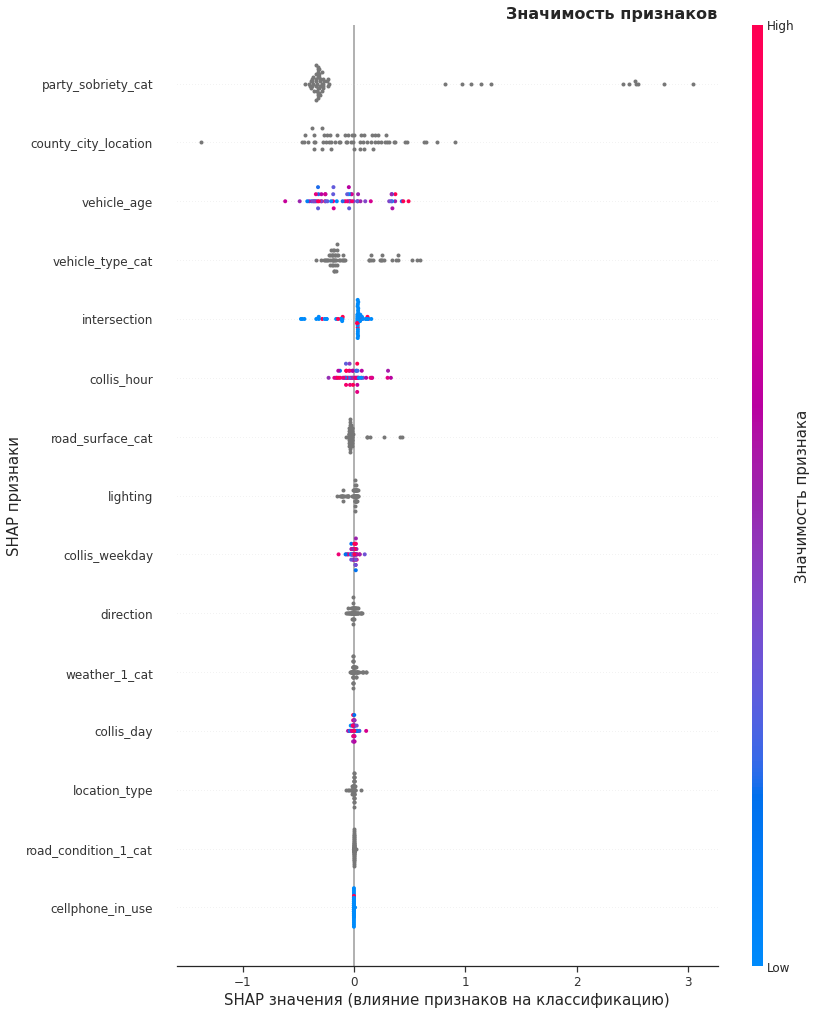

In [163]:
shap.summary_plot(shap_values, X_test_lgbm[:60], plot_size=(12, 14), show=False)
# Get the current figure and axes objects. from @GarrettCGraham code
fig, ax = plt.gcf(), plt.gca()

# Modifying main plot parameters
ax.tick_params(labelsize=12)
ax.set_xlabel("SHAP значения (влияние признаков на классификацию)", fontsize=15)
ax.set_ylabel("SHAP признаки", fontsize=15)
ax.set_title('Значимость признаков', fontsize=16, weight='bold', loc='right')

# Get colorbar
cb_ax = fig.axes[1]

# Modifying color bar parameters
cb_ax.tick_params(labelsize=12)
cb_ax.set_ylabel("Значимость признака", fontsize=15)

plt.show()

- Самым важным признаком оказался трезвость водителя.
- Следом два категориальных признака `тип автомобиля` и `возраст автомобиля`.
- Из числовых сильнее всего влияет время суток.

#### Дополнительный анализ фактора

In [164]:
count_df = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [165]:
count_df

,intersection,lighting,county_city_location,direction,location_type,cellphone_in_use,vehicle_age,collis_day,collis_weekday,collis_hour,weather_1_cat,road_surface_cat,road_condition_1_cat,party_sobriety_cat,vehicle_type_cat,at_fault
0,0.00,daylight,3020,north,highway,0.00,10.00,8,6,16.00,clear,dry,bad,had not been drinking,sedan,1
1,0.00,dark with no street lights,5000,north,ramp,0.00,7.00,23,0,4.00,cloudy/precipitation,slippery,normal,had not been drinking,sedan,1
2,0.00,dark with no street lights,3600,north,highway,0.00,3.00,17,5,6.00,cloudy/precipitation,dry,normal,had not been drinking,sedan,0
3,0.00,dark with no street lights,3029,east,None,0.00,3.00,5,3,20.00,clear,dry,normal,had been drinking,sedan,1
4,1.00,daylight,5000,None,None,0.00,7.00,2,0,12.00,clear,dry,normal,had not been drinking,sedan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42313,0.00,daylight,1942,east,None,0.00,3.00,21,5,13.00,clear,dry,normal,had not been drinking,sedan,0
42314,0.00,daylight,1942,east,highway,0.00,2.00,14,2,14.00,clear,dry,normal,had not been drinking,sedan,0
42315,0.00,daylight,1500,north,highway,0.00,4.00,12,1,11.00,clear,dry,bad,had not been drinking,sedan,0
42316,0.00,daylight,1942,north,highway,0.00,5.00,7,0,16.00,clear,dry,normal,had not been drinking,sedan,0


In [166]:
count_df = count_df.groupby(['collis_hour', 'at_fault']).size().reset_index(name='count')

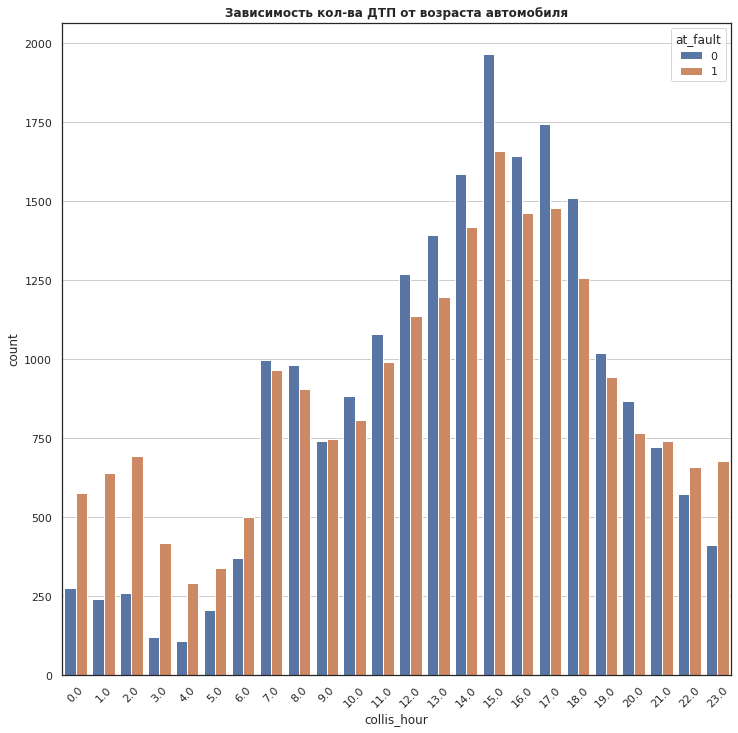

In [167]:
sns.barplot(x="collis_hour", y='count', hue="at_fault", data=count_df)
plt.title('Зависимость кол-ва ДТП от возраста автомобиля', weight='bold')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

Начиная с 9 вечера кол-во виновных в ДТП растет. Отчасти это может быть связано с усталостью водителя, а также низкой освещенностью. 
Как решение можно предложить поставить датчики, которые будут учитывать поведение водителя на дороге, а также камеру, которая будет следить за глазами водителя. Такое решение уже внедрил, например, volkswagen.

## Анализ матрицы ошибок

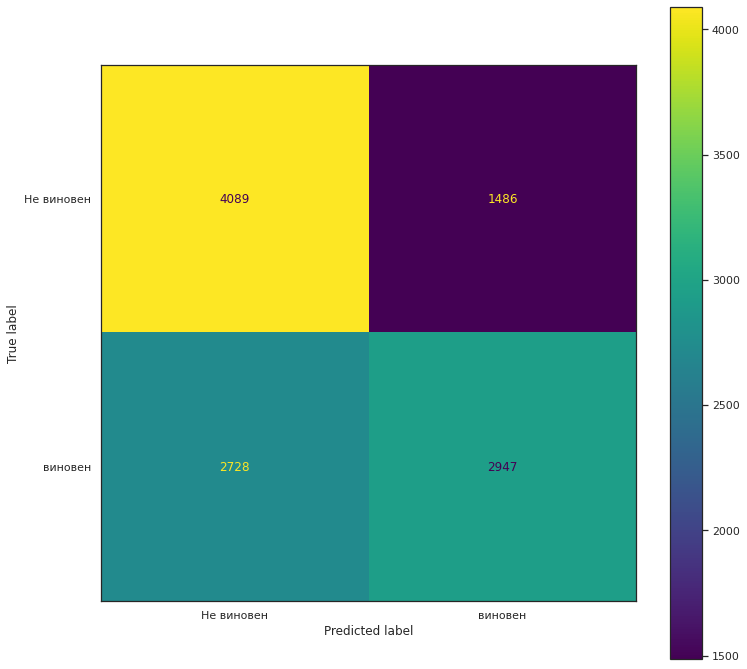

In [168]:
sns.set_theme(style="white")
cm = confusion_matrix(y_test, pred_y)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Не виновен', 'виновен'])
disp.plot()

plt.show()

In [169]:
print(f'Recall: {round(recall_score(y_test, pred_y), 3)}')
print(f'Precision: {round(precision_score(y_test, pred_y), 3)}')
print(f'AUC:{round(roc_auc_score(y_test, y_proba), 3)}')
print(f'F1:{round(f1_score(y_test, pred_y), 3)}')

Recall: 0.519
Precision: 0.665
AUC:0.678
F1:0.583


Чтобы избавиться от всех значений FN необходимо выставить порог 0, но это не оптимально, поэтому нужно искать баланс.

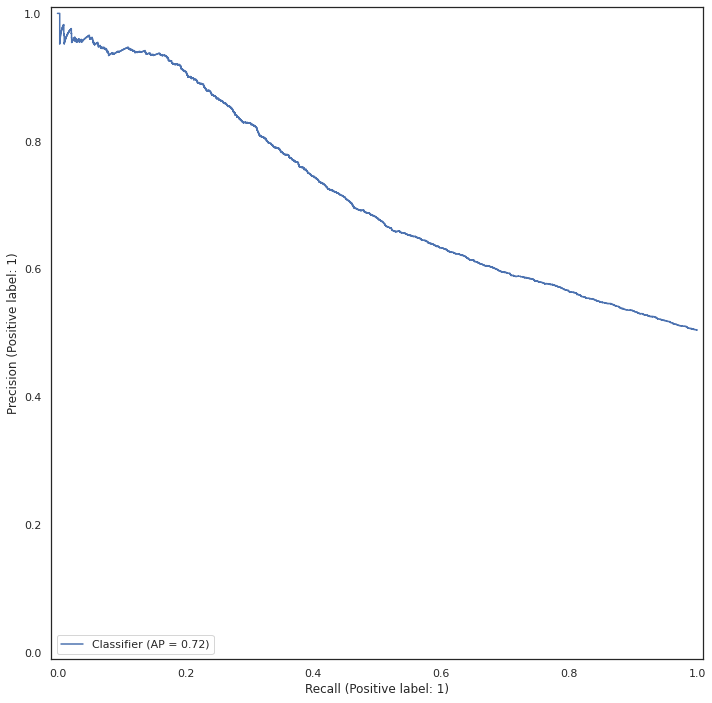

In [170]:
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.show()

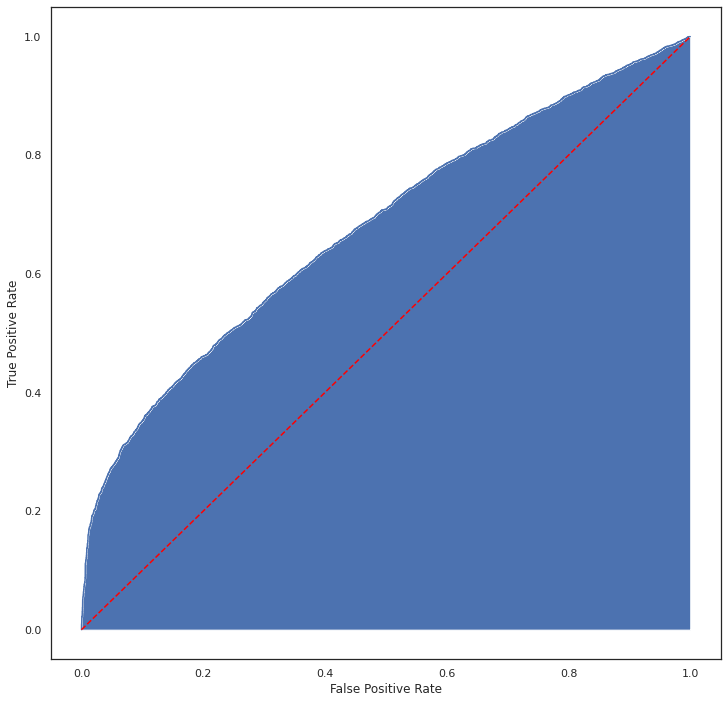

AUC: 0.678


In [171]:
fpr, tpr, thres = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

auc = roc_auc_score(y_test, y_proba)
plt.fill_between(fpr, tpr)
plt.show()
print("AUC: %.3f" % auc)

In [172]:
# Вычисление AUC
roc_auc = roc_auc_score(y_test, y_proba)

# Поиск оптимального порога по TPR и FPR
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thres[optimal_idx]

print("Оптимальный порог для максимизации TPR-FPR:", optimal_threshold)
print("Максимальный AUC:", roc_auc)

Оптимальный порог для максимизации TPR-FPR: 0.5438078645106592
Максимальный AUC: 0.6784632464787341


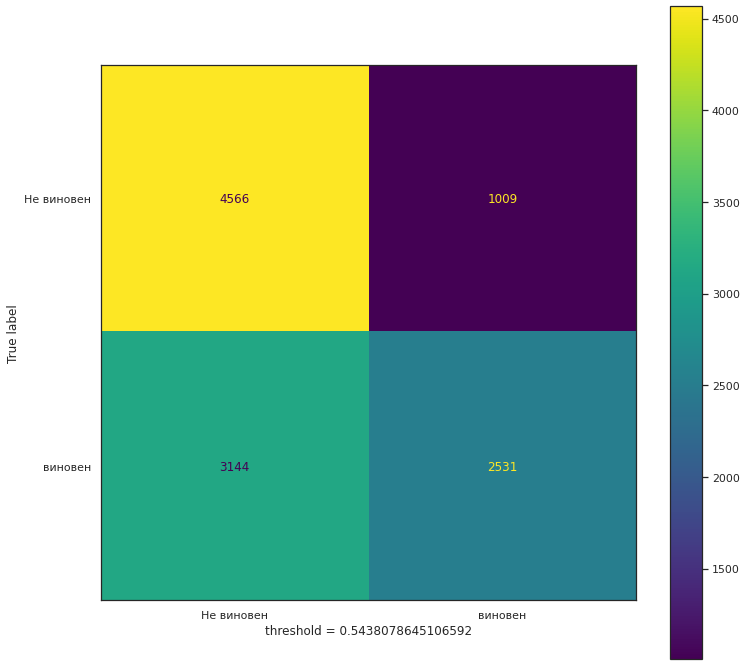

In [173]:
y_proba_tweak = np.where(y_proba > optimal_threshold, 1, 0)
cm_new = confusion_matrix(y_test, y_proba_tweak)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=['Не виновен', 'виновен'])
disp.plot()
plt.xlabel(f'threshold = {optimal_threshold}')
plt.show()

In [174]:
print(f'Recall: {round(recall_score(y_test, y_proba_tweak), 3)}')
print(f'Precision: {round(precision_score(y_test, y_proba_tweak), 3)}')
print(f'AUC:{round(roc_auc_score(y_test, y_proba), 3)}')
print(f'F1:{round(f1_score(y_test, y_proba_tweak), 3)}')

Recall: 0.446
Precision: 0.715
AUC:0.678
F1:0.549


Оптимальный порог 0.54, но нужна консультация с бизнесом, чтобы понять размер суммы, которую теряют на водителях с высоким риском ДТП.

In [175]:
best_model

LGBMClassifier(max_depth=5, min_child_samples=50, num_leaves=20,
               objective='binary', random_state=15)

## Выводы

**Описание модели**

| Параметр                                  | Значение                                                           |
|-------------------------------------------|--------------------------------------------------------------------|
| Алгоритм                                  | LGBMClassifier| 
|  |max_depth=5|
| |min_child_samples=50|
| |num_leaves=20|
| Метод заполнение категориальных пропусков | SimpleImputer(copy=False, fill_value='other', strategy='constant') |
| Метод заполнения числовых признаков       | KNNImputer(weights='distance')                                     |

Проект показал, что в целом можно выявить водителей с выскоим риском виновности в ДТП, но при этом необходимо понять сколько денег теряет бизнес на виновных водителях, чтобы принять решение по донастройке модели.

Для улучшения предсказаний можно добавить следующее:
- При регистрации запрашивать номер водительского удостоверения, а также иметь доступ к данным по нарушениям водителя, его стаж.
- Оборудовать навигатором автомобили и строить маршрут используя, только штатный. Так мы сможем подбирать самый оптимальный маршрут, который **снизит риск ДТП в целом.**
- Оборудовать автомобиль датчиками, которые смогу считывать стиль вождения.
- Оборудовать автомобиль камерой/видеорегистратором, чтобы отслеживать состояние водителя.

[Вернуться в начало тетрадки](#head)